In [1]:
import numpy as np
import os
import numpy as np
import glob
from matplotlib import pyplot as plt
from skimage.transform import resize
from skimage.measure import label, regionprops
import math
from glob import glob
import re
import json

In [2]:
from model.MultiResUnet import MultiResUnet
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import Sequence
import keras.backend as K

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.
D:\Programas\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Programas\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Programas\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Programas\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: Fu

In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
set_session(tf.Session(config=config))

In [4]:
n_classes = 2
chanels = 1
mask_size = np.array([256, 256])

In [5]:
def get_data_mask(path):
    file = np.load(path)
    data = file['data']
    mask = file['mask']
    file.close()
    data = resize(data, mask_size)
    mask = resize(mask, mask_size, order=0, anti_aliasing=False, preserve_range=True).astype(np.int16)      
    return data, mask

In [6]:
class Sequence_data(Sequence):

    def __init__(self, data, batch_size):
        # recive una lista de rutas de donde están los volumenes como numpy arrays y el batch_size
        self.data = data
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.data) / float(self.batch_size)))

    def __getitem__(self, idx):
        # lista de rutas para el batch actual
        batch_x = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        X = []
        y = []
        
        # se cargan los volumenes y las mascaras en sus respectivos arrays
        for path in batch_x:
            
            data, mask = get_data_mask(path)
            X.append(data)

            temp = to_categorical(mask)
            if(temp.shape[2] == 1):
                temp = np.concatenate([temp, temp], -1)
            y.append(temp)
            
        X = np.array(X)
        y = np.array(y)
        
        return X.reshape(-1, mask_size[0], mask_size[1], chanels), y.reshape(-1, mask_size[0], mask_size[1], n_classes)
    
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.constant(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss
    
def get_model_memory_usage(batch_size, model):
    import numpy as np
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    number_size = 4.0
    if K.floatx() == 'float16':
         number_size = 2.0
    if K.floatx() == 'float64':
         number_size = 8.0

    total_memory = number_size*(batch_size*shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes
    
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [7]:
def dice_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = K.flatten(y_true[...,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [8]:
paths_train = glob('./data/train/*.npz')
paths_test = glob('./data/test/*.npz')

In [ ]:
counts = np.zeros(n_classes)
n_samples = np.int64()

for path in paths_train:
    data, mask = get_data_mask(path)
    mask = mask.flatten()
    n_samples += len(mask)
    vals, count = np.unique(mask, return_counts=True)
    for i, j in enumerate(vals):
        counts[j] = counts[j] + count[i].astype(np.int64)
        
counts / n_samples
weights = n_samples / (n_classes * counts)
print('weights:', weights)

In [ ]:
weights.max()

In [ ]:
weights.min()

In [ ]:
weights

In [9]:
weights = np.array([0.5, 70])

In [10]:
seq_train = Sequence_data(paths_train, 8)
seq_test = Sequence_data(paths_test, 8)

In [11]:
model = MultiResUnet(mask_size[0], mask_size[1], chanels, n_classes)

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
model.compile(optimizer='Adadelta', loss=weighted_categorical_crossentropy(weights), metrics=['acc',jaccard_distance, dice_coef])

In [13]:
ES = EarlyStopping(patience=10, min_delta=0.00001, restore_best_weights=True)
MCP = ModelCheckpoint(filepath="./weights/weights.{epoch:02d}.hdf5", save_best_only=True, save_weights_only=True)
callbacks = [ES, MCP]

In [14]:
get_model_memory_usage(8, model)

7.362

In [15]:
history = model.fit_generator(seq_train, initial_epoch=0, validation_data=seq_test, steps_per_epoch=int(len(paths_train)/8), epochs=200, callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/200


D:\Programas\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
D:\Programas\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


1469/1469 [==============================] - 618s 421ms/step - loss: 0.3048 - acc: 0.8832 - jaccard_distance: 0.7671 - dice_coef: 0.0050 - val_loss: 0.3058 - val_acc: 0.9628 - val_jaccard_distance: 0.5638 - val_dice_coef: 0.0070
Epoch 2/200
1469/1469 [==============================] - 618s 421ms/step - loss: 0.2039 - acc: 0.9734 - jaccard_distance: 0.4526 - dice_coef: 0.0084 - val_loss: 0.3006 - val_acc: 0.9908 - val_jaccard_distance: 0.2689 - val_dice_coef: 0.0123
Epoch 3/200
1469/1469 [==============================] - 603s 410ms/step - loss: 0.1875 - acc: 0.9892 - jaccard_distance: 0.2032 - dice_coef: 0.0189 - val_loss: 0.3456 - val_acc: 0.9961 - val_jaccard_distance: 0.1571 - val_dice_coef: 0.0195
Epoch 4/200
1469/1469 [==============================] - 593s 403ms/step - loss: 0.1894 - acc: 0.9928 - jaccard_distance: 0.1401 - dice_coef: 0.0298 - val_loss: 0.3798 - val_acc: 0.9967 - val_jaccard_distance: 0.1145 - val_dice_coef: 0.0297
Epoch 5/200
1469/1469 [=========================

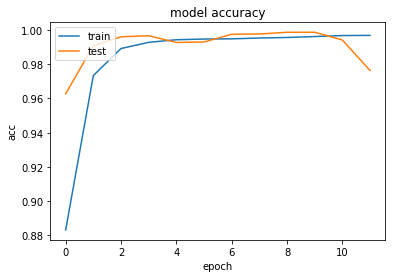

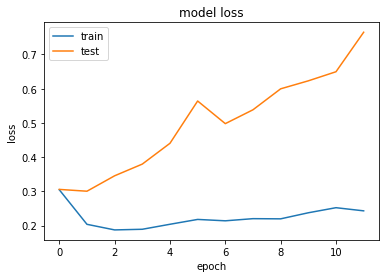

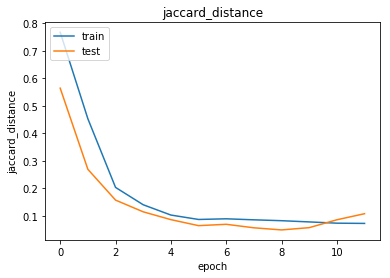

In [16]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['jaccard_distance'])
plt.plot(history.history['val_jaccard_distance'])
plt.title('jaccard_distance')
plt.ylabel('jaccard_distance')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import subprocess
subprocess.call("shutdown -s")

In [ ]:
np.stack([[0,0,0], [0,0,0]], -1).shape

In [17]:
data, mask = get_data_mask('./data/train/10142.npz')

D:\Programas\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
D:\Programas\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [18]:
model.load_weights('./weights/weights.02.hdf5')

In [19]:
pred = model.predict(data.reshape(1, mask_size[0], mask_size[1], 1))[0]

In [20]:
pred.shape

(256, 256, 2)

In [21]:
pred.min()

0.002362311

In [22]:
pred.max()

1.0

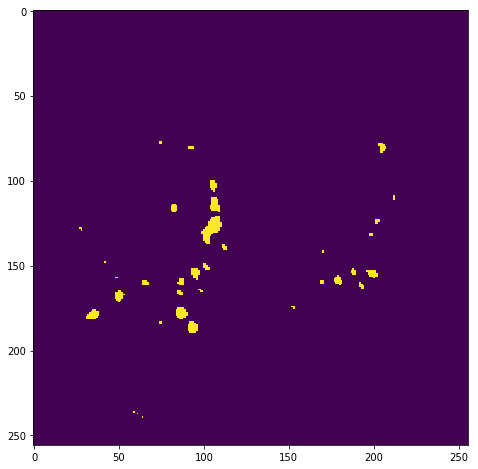

In [23]:
plt.figure(figsize=(8,8))
plt.imshow(pred[..., 1]>0.6)

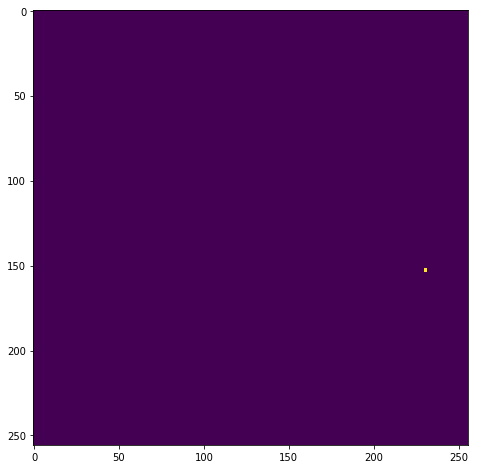

In [25]:
plt.figure(figsize=(8,8))
plt.imshow(mask)